### LDA Optimization
This notebook explores some potential optimization metrics for Latent Dirichlet Allocation. This topic modelling technique is sophisticated but can be difficult to interpret and tune. As such, it is often necessary to optimize a model to several internal or imposed parameters. This notebook includes a more involved preprocessing stage than others because text normalization is very important for this topic model.

In [191]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import fasttext as ft
import numpy as np
import scipy.spatial.distance as distance
from sklearn.metrics import silhouette_score
import re
from sklearn.linear_model import LinearRegression
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from bs4 import BeautifulSoup
import string
import plotly.graph_objects as go
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Christian\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Christian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [192]:
# Get stopwords list.
from nltk.corpus import stopwords
sw_en = stopwords.words('english')

In [193]:
# Load both the datasets.
df = pd.read_csv('res/bbc.csv')

In [194]:
# Get average comment length.
print(sum(map(lambda x: len(x), df['text'])) / len(df))

2290.354


In [195]:
# Apostrophe Dictionary and if you have more words in mind, please add it in the bottom
apostrophe = {
    "aren't" : "are not",
    "can't" : "cannot",
    "couldn't" : "could not",
    "didn't" : "did not",
    "doesn't" : "does not",
    "don't" : "do not",
    "hadn't" : "had not",
    "hasn't" : "has not",
    "haven't" : "have not",
    "he'd" : "he would",
    "he'll" : "he will",
    "he's" : "he is",
    "i'd" : "I would",
    "i'd" : "I had",
    "i'll" : "I will",
    "i'm" : "I am",
    "isn't" : "is not",
    "it's" : "it is",
    "it'll":"it will",
    "i've" : "I have",
    "let's" : "let us",
    "mightn't" : "might not",
    "mustn't" : "must not",
    "shan't" : "shall not",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "shouldn't" : "should not",
    "that's" : "that is",
    "there's" : "there is",
    "they'd" : "they would",
    "they'll" : "they will",
    "they're" : "they are",
    "they've" : "they have",
    "we'd" : "we would",
    "we're" : "we are",
    "weren't" : "were not",
    "we've" : "we have",
    "what'll" : "what will",
    "what're" : "what are",
    "what's" : "what is",
    "what've" : "what have",
    "where's" : "where is",
    "who'd" : "who would",
    "who'll" : "who will",
    "who're" : "who are",
    "who's" : "who is",
    "who've" : "who have",
    "won't" : "will not",
    "wouldn't" : "would not",
    "you'd" : "you would",
    "you'll" : "you will",
    "you're" : "you are",
    "you've" : "you have",
    "'re": " are",
    "wasn't": "was not",
    "we'll":" will",
    "didn't": "did not",
    "'s": "is",
    "'re": "are"
}

#Short words dictionary and if have more words in mind, please add it in the bottom
short_words = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

def apos_short_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

df.head(5)

,text,label
0,French wine gets 70m euro top-up The French g...,business
1,Steady job growth continues in US The US crea...,business
2,S&N extends Indian beer venture The UK's bigg...,business
3,Unilever shake up as profit slips Anglo-Dutch...,business
4,Circuit City gets takeover offer Circuit City...,business


In [196]:
def remove_html(txt):
    '''Remove HTML'''
    txt = BeautifulSoup(txt, 'lxml')
    return txt.get_text()

def remove_punctuation(text):
    '''Remove any punctuation'''
    return "".join([i for i in text if i not in string.punctuation])

def remove_stopwords(text):
    '''Remove stop words'''
    return " ".join([w for w in text.split() if w not in stopwords.words('english')])   

def preprocessing(txt, punctuation= False, stopwords= False, correct_apos= False, 
                  shortWords= False, specialCharacter= False, numbers= False, singleChar= False):
    
    cleanedTxt = txt.apply(lambda x: remove_html(x))
    
    if punctuation:
        cleanedTxt = cleanedTxt.apply(lambda x:remove_punctuation(x))
        
    if stopwords:
        cleanedTxt = cleanedTxt.apply(lambda x: remove_stopwords(x))
        
    if correct_apos:
        cleanedTxt = cleanedTxt.apply(lambda x: apos_short_dict(str(x),apostrophe))
        
    if shortWords:
        cleanedTxt = cleanedTxt.apply(lambda x: apos_short_dict(str(x),short_words))
    
    if specialCharacter:
        '''Replacing Special Characters with space'''
        cleanedTxt = cleanedTxt.apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',str(x)))
    
    if numbers:
        '''Replacing Numbers with space'''
        cleanedTxt = cleanedTxt.apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x))
        
    if singleChar:
        '''Removing words whom length is one'''
        cleanedTxt = cleanedTxt.apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
    
    return cleanedTxt
      
df['comments'] = preprocessing(df['text'], punctuation= True, stopwords= True, 
                                correct_apos= True, shortWords= True, specialCharacter= True, 
                               numbers= True, singleChar= True)
df.head()

,text,label,comments
0,French wine gets 70m euro top-up The French g...,business,French wine gets euro topup The French governm...
1,Steady job growth continues in US The US crea...,business,Steady job growth continues US The US created ...
2,S&N extends Indian beer venture The UK's bigg...,business,SN extends Indian beer venture The UKs biggest...
3,Unilever shake up as profit slips Anglo-Dutch...,business,Unilever shake profit slips AngloDutch consume...
4,Circuit City gets takeover offer Circuit City...,business,Circuit City gets takeover offer Circuit City ...


In [197]:
data_words = df['comments'].apply(lambda x: x.lower().split()).tolist()

In [198]:
tqdm.pandas()

In [199]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# 1. Init Lemmatizer
lemmatizer = WordNetLemmatizer()
df['trigram_words'] = [' '.join(words) for words in data_words]
nltk.download('punkt')

def Lemmatize (text):
      return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    
df['text'] = df['trigram_words'].progress_apply(lambda x: Lemmatize(x))
df.head(5)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Christian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,label,comments,trigram_words
0,"[french, wine, get, euro, topup, the, french, ...",business,French wine gets euro topup The French governm...,french wine gets euro topup the french governm...
1,"[steady, job, growth, continue, u, the, u, cre...",business,Steady job growth continues US The US created ...,steady job growth continues us the us created ...
2,"[sn, extends, indian, beer, venture, the, uk, ...",business,SN extends Indian beer venture The UKs biggest...,sn extends indian beer venture the uks biggest...
3,"[unilever, shake, profit, slip, anglodutch, co...",business,Unilever shake profit slips AngloDutch consume...,unilever shake profit slips anglodutch consume...
4,"[circuit, city, get, takeover, offer, circuit,...",business,Circuit City gets takeover offer Circuit City ...,circuit city gets takeover offer circuit city ...


In [200]:
df['text'].head()

0    [french, wine, get, euro, topup, the, french, ...
1    [steady, job, growth, continue, u, the, u, cre...
2    [sn, extends, indian, beer, venture, the, uk, ...
3    [unilever, shake, profit, slip, anglodutch, co...
4    [circuit, city, get, takeover, offer, circuit,...
Name: text, dtype: object

In [201]:
# Create dictionary and corpus for each dataset.
dictionary = Dictionary(df['text'])
dictionary.filter_extremes(no_below=1, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in df['text']]

In [202]:
# Instantiate range of topics to try.
range_n_topics = list(range(2, 21))

In [17]:
# Load fasttext model
ft_model = ft.load_model('C:/Users/Christian/Desktop/crawl-300d-2M-subword.bin')

In [203]:
# Get word embedding for each word id in the dictionary of each corpus.
id2emb1 = {}
for i, token in tqdm(dictionary.items()):
    id2emb1[i] = ft_model[token]

In [20]:
def get_average_variance_score_for_lda_model_topics(model, lang):
    '''
    Compute an average variance score across LDA topics,
    using topic word embeddings and SSE.
    
    Parameters
    ---------
        model : LdaModel
            Trained model.
        lang : str
            Language model to use.
            
    Returns
    ---------
        variance_score : float
            Average variance for topics.
    '''
    if lang == 'en':
        id2emb = id2emb2
    elif lang == 'de':
        id2emb = id2emb1
    
    topics = model.print_topics(num_topics=-1, num_words=20)    
    variance_scores = []
    for topic_id, _ in topics:
        words = model.get_topic_terms(topic_id)
        word_embeddings = []
        for word_id, _ in words:
            word_embeddings.append(id2emb[word_id])
            
        centroid = np.mean(word_embeddings, axis=0)
        distances = []
        for embedding in word_embeddings:
            distances.append(distance.cosine(embedding, centroid)**2)
            
        variance_scores.append(sum(distances))
        
    return sum(variance_scores) / len(variance_scores)      

In [21]:
# Silhouette
def get_average_silhouette_score_for_lda_model_topics(model, lang):
    '''
    Compute an average silhouette score by using a tokens'
    maximum probability topic as a cluster label, then using
    these assignments to compute a silhouette score across
    the tokens for each topic.
    
    Parameters
    ---------
        model : LdaModel
            Trained model.
        land : str
            Language model to use.
            
    Returns
    ---------
        silhouette_score : float
            Average silhouette score for topics.
    '''
    if lang == 'en':
        id2emb = id2emb2
    elif lang == 'de':
        id2emb = id2emb1
        
    labels = []
    for array in np.transpose(model.get_topics()):
        labels.append(np.argmax(array))
      
    X = np.array(list(id2emb.values()))
        
    return silhouette_score(X, labels, random_state=42, sample_size=1000)

In [22]:
# Average of summed related token weights.
def get_average_inter_topic_correlated_word_weights(model, lang, threshold=0.5):
    '''
    Compute an average sum of the inter-topic word
    probabilities for only those words which exist in 
    a cosine distance below an arbitrary threshold 
    connoting similarity.
    
    Parameters
    ---------
        model : LdaModel
            Trained model.
        lang : str
            Language model to use.
        threshold : float
            Distance threshold for considering
            two tokens to be semantically-related.
            
    Returns
    ---------
        average_summed_weights : float
            Average of summed weights.
    '''
    if lang == 'en':
        id2emb = id2emb2
    elif lang == 'de':
        id2emb = id2emb1
    
    weights_all_topics = []
    topics = model.print_topics(num_topics=-1, num_words=10)
    for i, (topic_id1, _) in enumerate(topics):
        weights = []
        words_in_current_topic = model.get_topic_terms(topic_id1, topn=20)
        for word_id1, probability1 in words_in_current_topic:
            weights_in_other_topics = []
            for j, (topic_id2, _) in enumerate(topics):
                if i == j:
                    continue
                    
                weights_of_other_words = 0
                words_in_other_topic = model.get_topic_terms(topic_id2, topn=20)
                for word_id2, probability2 in words_in_other_topic:
                    d = distance.cosine(id2emb[word_id1], id2emb[word_id2])
                    if d < threshold:
                        weights_of_other_words += probability2
                        
                weights_in_other_topics.append(weights_of_other_words)
    
            weights.append(sum(weights_in_other_topics) / len(weights_in_other_topics))
                        
        weights = sum(weights) / len(weights)
        weights_all_topics.append(weights)

    return sum(weights_all_topics) / len(weights_all_topics)

In [204]:
# Run lda for the first corpus, plotting coherence value.
coherence_umass = []
variance = []
summed_weights = []
silhouette = []
for i in tqdm(range_n_topics):
    lda = LdaModel(corpus, id2word=dictionary, num_topics=i, random_state=42,
                   alpha='asymmetric', per_word_topics=True, minimum_phi_value=0.02)
    cm_umass = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
    coherence_umass.append(cm_umass.get_coherence())
    variance.append(get_average_variance_score_for_lda_model_topics(lda, lang='de'))
    summed_weights.append(get_average_inter_topic_correlated_word_weights(lda, lang='de'))
    silhouette.append(get_average_silhouette_score_for_lda_model_topics(lda, lang='de'))

In [205]:
# Adjust seaborn styling.
sns.set_style("whitegrid")
sns.set_palette('Set2')

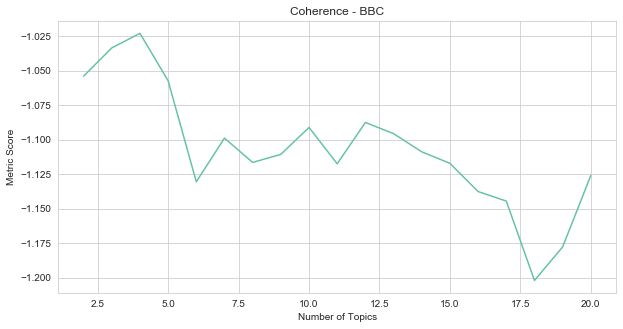

In [206]:
# Plot coherence for different n_topics.
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)
ax1.set_title('Coherence - BBC')
plt.plot(range_n_topics, coherence_umass)

ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Metric Score')
plt.show()

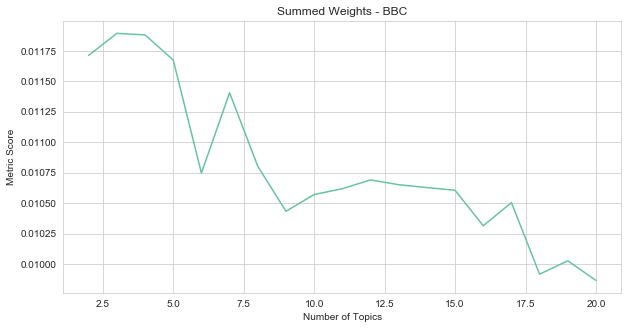

In [207]:
# Plot average summed weights for different n_topics.
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)
ax1.set_title('Summed Weights - BBC')
plt.plot(range_n_topics, summed_weights)

ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Metric Score')
plt.show()

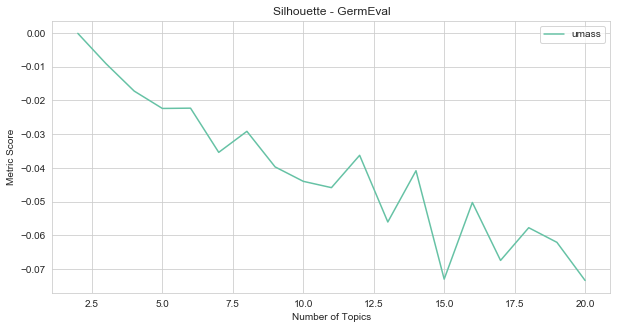

In [208]:
# Plot average silhouette for different n_topics.
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)
ax1.set_title('Silhouette - GermEval')
plt.plot(range_n_topics, silhouette)

ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Metric Score')
plt.legend(['umass', 'silhouette'])
plt.show()

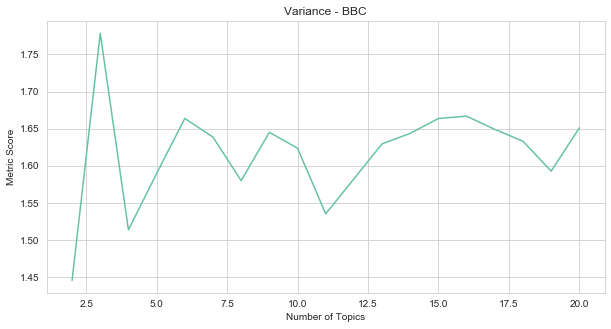

In [209]:
# Plot variance against n_topics.
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)
ax1.set_title('Variance - BBC')
plt.plot(range_n_topics, variance)

ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Metric Score')
plt.show()

In [210]:
# Exploring the topics at n=5.
lda = LdaModel(corpus, id2word=dictionary, num_topics=5, random_state=42, alpha='asymmetric', per_word_topics=True, minimum_phi_value=0.02)
for topic in lda.print_topics(num_topics=-1):
    print(topic)

(0, '0.005*"mr" + 0.004*"u" + 0.004*"people" + 0.004*"new" + 0.004*"but" + 0.004*"get" + 0.004*"he" + 0.003*"one" + 0.003*"film" + 0.003*"could"')
(1, '0.008*"mr" + 0.005*"best" + 0.005*"one" + 0.004*"people" + 0.004*"get" + 0.004*"go" + 0.004*"time" + 0.003*"government" + 0.003*"world" + 0.003*"take"')
(2, '0.005*"take" + 0.005*"mr" + 0.005*"game" + 0.004*"he" + 0.004*"first" + 0.004*"but" + 0.004*"people" + 0.003*"last" + 0.003*"could" + 0.003*"new"')
(3, '0.009*"mr" + 0.005*"people" + 0.005*"u" + 0.004*"new" + 0.004*"use" + 0.004*"game" + 0.003*"but" + 0.003*"one" + 0.003*"uk" + 0.003*"he"')
(4, '0.005*"mr" + 0.005*"new" + 0.004*"go" + 0.004*"people" + 0.004*"take" + 0.004*"he" + 0.004*"one" + 0.004*"show" + 0.004*"but" + 0.004*"u"')


### NOTE
As demonstrated, it is difficult to infer an optimal n topics from these data (although some metrics suggest a value around 5 is the optimal n_topics, which does agree with the original number of classes in the dataset), given that many metrics have a strong correlation with the number of topics. The next avenue to explore is a combination of the metrics which may lead to more obvious minima/maxima. First we will examine correlations between the existing metrics.

In [211]:
reg = LinearRegression().fit(np.array(coherence_umass).reshape(-1, 1), np.array(summed_weights).reshape(-1, 1))
line = reg.predict(np.array(coherence_umass).reshape(-1, 1))

In [212]:
reg.score(np.array(coherence_umass).reshape(-1, 1), np.array(summed_weights).reshape(-1, 1))

0.7732053473510289

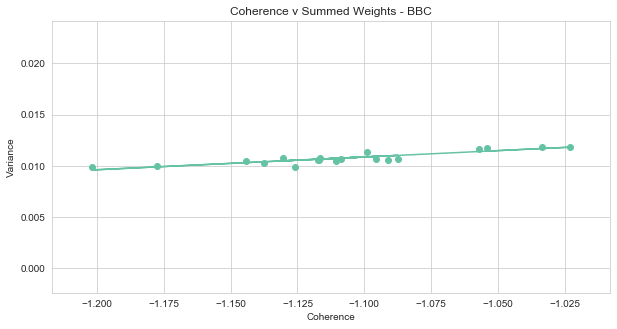

In [213]:
# Plot variance against coherence to see if a correlation is suggested.
fig3cv = plt.figure(figsize=(10, 5))
ax3cv = fig3cv.add_subplot(111)
ax3cv.set_title('Coherence v Summed Weights - BBC')
plt.scatter(coherence_umass, summed_weights)
plt.plot(coherence_umass, line)

ax3cv.set_xlabel('Coherence')
ax3cv.set_ylabel('Variance')
plt.show()

### NOTE
The coherence and summed weights values have a mild correlation.

In [214]:
reg = LinearRegression().fit(np.array(variance).reshape(-1, 1), np.array(silhouette).reshape(-1, 1))
line = reg.predict(np.array(variance).reshape(-1, 1))

In [215]:
reg.score(np.array(variance).reshape(-1, 1), np.array(silhouette).reshape(-1, 1))

0.08791733717568939

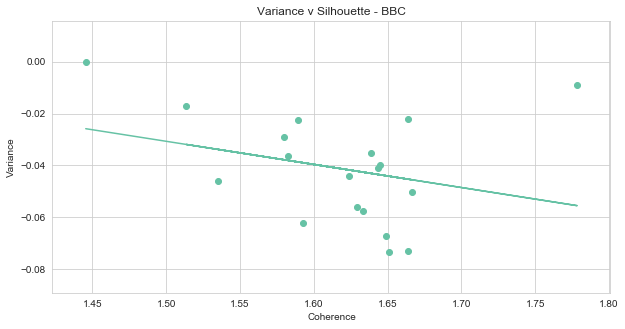

In [216]:
# Plot variance against coherence to see if a correlation is suggested.
fig3cv = plt.figure(figsize=(10, 5))
ax3cv = fig3cv.add_subplot(111)
ax3cv.set_title('Variance v Silhouette - BBC')
plt.scatter(variance, silhouette)
plt.plot(variance, line)

ax3cv.set_xlabel('Coherence')
ax3cv.set_ylabel('Variance')
plt.show()

### NOTE
Silhouette and variance show a weak correlation.

In [146]:
# Average of summed related token weights.
def get_average_inter_topic_correlated_word_weights(model, lang, threshold=0.5):
    '''
    Compute an average sum of the inter-topic word
    probabilities for only those words which exist in 
    a cosine distance below an arbitrary threshold 
    connoting similarity.
    
    Parameters
    ---------
        model : LdaModel
            Trained model.
        threshold : float
            Distance threshold for considering
            two tokens to be semantically-related.
            
    Returns
    ---------
        average_summed_weights : float
            Average of summed weights.
    '''
    id2emb = id2emb1
    
    weights_all_topics = []
    topics = model.print_topics(num_topics=-1, num_words=10)
    for i, (topic_id1, _) in enumerate(topics):
        weights = []
        words_in_current_topic = model.get_topic_terms(topic_id1, topn=20)
        for word_id1, probability1 in words_in_current_topic:
            weights_in_other_topics = []
            for j, (topic_id2, _) in enumerate(topics):
                if i == j:
                    continue
                    
                weights_of_other_words = 0
                words_in_other_topic = model.get_topic_terms(topic_id2, topn=20)
                for word_id2, probability2 in words_in_other_topic:
                    d = distance.cosine(id2emb[word_id1], id2emb[word_id2])
                    if d < threshold:
                        weights_of_other_words += probability2
                        
                weights_in_other_topics.append(weights_of_other_words)
    
            weights.append(sum(weights_in_other_topics) / len(weights_in_other_topics))
                        
        weights = sum(weights) / len(weights)
        weights_all_topics.append(weights)

    return sum(weights_all_topics) / len(weights_all_topics)

In [147]:
def rescale(point, l):
    mx, mn = max(l), min(l)
    
    return ((point - mn) / (mx - mn)) * (1 - 0) + 0

In [217]:
# Run lda for the third corpus, plotting metrics with various random states.
df_log = []
for i in tqdm(range_n_topics):
    for j in tqdm(range(8, 20)):
        # LDA
        lda = LdaModel(corpus, id2word=dictionary, num_topics=i, random_state=j)
        # Coherence
        cm_umass = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
        coherence = cm_umass.get_coherence()
        # Penalty
        penalty = get_average_inter_topic_correlated_word_weights(lda, lang='en')
        # Log a row
        log_row = {
            'n_topics': i,
            'random_state': j,
            'coherence (umass)': coherence,
            'penalty': penalty,
        }
        df_log.append(log_row)

In [218]:
df_log = pd.DataFrame(df_log)

In [219]:
fig = go.Figure(data=[go.Mesh3d(x=df_log['n_topics'],
                   y=df_log['coherence (umass)'].apply(lambda x: 1- rescale(x, l=df_log['coherence (umass)'])),
                   z=df_log['penalty'],
                   opacity=0.5,
                   color='rgba(244,22,100,0.6)'
                  )])
fig.show()

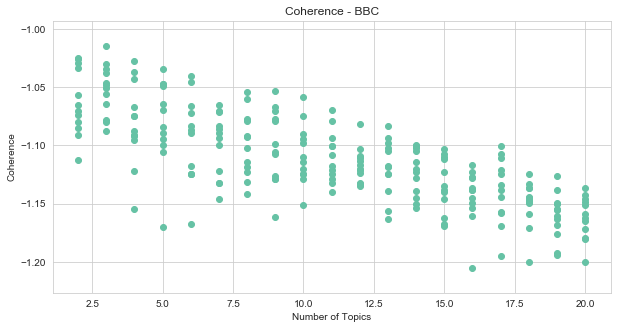

In [220]:
# Try some other graphs to see if any pattern emerges
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(111)
ax3.set_title('Coherence - BBC')
plt.scatter(df_log['n_topics'], df_log['coherence (umass)'])
ax3.set_xlabel('Number of Topics')
ax3.set_ylabel('Coherence')
plt.show()

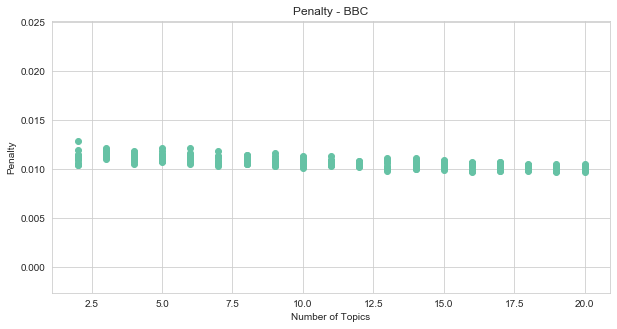

In [221]:
# Try some other graphs to see if any pattern emerges
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(111)
ax3.set_title('Penalty - BBC')
plt.scatter(df_log['n_topics'], df_log['penalty'])
ax3.set_xlabel('Number of Topics')
ax3.set_ylabel('Penalty')
plt.show()

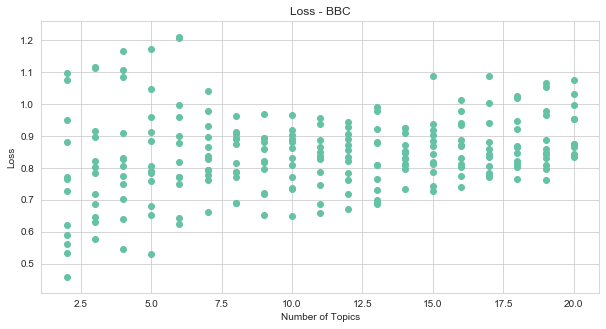

In [222]:
loss = []
for _, row in df_log.iterrows():
    coherence = 1- rescale(row['coherence (umass)'], l=df_log['coherence (umass)'])
    penalty = rescale(row['penalty'], l=df_log['penalty'])
    loss.append(coherence + penalty)
    
# Try some other graphs to see if any pattern emerges
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(111)
ax3.set_title('Loss - BBC')
plt.scatter(df_log['n_topics'], loss)
ax3.set_xlabel('Number of Topics')
ax3.set_ylabel('Loss')
plt.show()

In [223]:
minimum = loss.index(min(loss))
m = df_log.iloc[minimum]
lda = LdaModel(corpus, id2word=dictionary, num_topics=m['n_topics'], random_state=int(m['random_state']))
lda.print_topics(num_topics=-1)

[(0,
  '0.006*"mr" + 0.004*"get" + 0.004*"one" + 0.004*"people" + 0.004*"u" + 0.004*"but" + 0.004*"new" + 0.004*"take" + 0.004*"he" + 0.003*"game"'),
 (1,
  '0.007*"mr" + 0.005*"people" + 0.004*"new" + 0.004*"time" + 0.004*"u" + 0.004*"go" + 0.003*"he" + 0.003*"take" + 0.003*"one" + 0.003*"last"')]